# Kaggle competition - Base model

Initial exploration of the data

In [16]:
# Imports
import gc
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [3]:
sns.set_palette("coolwarm")
sns.set_theme()
sns.set(rc={'figure.figsize':(10,5)})
pd.options.display.float_format = '{:,.4f}'.format

In [4]:
logger_conf = logging.basicConfig(level=logging.INFO,
                             format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
                             datefmt="%m/%d/%Y %I:%M:%S%p")

LOGGER = logging.getLogger('BasicLogger')


In [4]:
# Loading the datasets
columns_dtypes={'ip': np.uint32,
                'app': np.uint16,
                'device': np.uint16,
                'os': np.uint16,
                'channel': np.uint16}

test_df = pd.read_csv('./fraud-detection-clicks/test.csv', dtype=columns_dtypes)


columns_dtypes['is_attributed'] = np.uint8
train_sample_df = pd.read_csv('./fraud-detection-clicks/train_sample.csv', dtype=columns_dtypes)
train_df = pd.read_csv('./fraud-detection-clicks/train.csv', dtype=columns_dtypes)

train_df['click_id'] = np.nan
train_df['ds_type'] = 'train'
test_df['attributed_time'] = np.nan
test_df['is_attributed'] = np.nan
test_df['ds_type'] = 'test'

# We concat the datasets since test contains the period 1-2 hours after the train ends, we will use that to evaluate the test features that look on history
ds_df = pd.concat([train_df, test_df])



## EDA conclusions recap:

#### Datasets & Classes
1. We see that we don't have any nulls except the attribution_time (which is expected for clicks without an insatallation).
2. The dataset is highly imbalance (only 0.24% of the samples has been attributed) - We will have to reflect this in the KPIs we try to optimize, in addition, depends on the problem goal, we might want to consider modifying the attributed sample's weights.

#### Base Features (raw data features)
**Correlation**

1. High correlation between the OS and device (which is expected), we might want to drop one of them prior to training.
2. Decent correlation between the device and os compared to the app (which is expected).
3. Some correlation for the label and IP / app -> This means that they might be features with higher importance.

**Unique Values**

1. We only see installs in 21% of the operating systems - We can try to understand in the future if there might be a lot of OS used by bots.
2. We see that almost all the channels get installations so even though different channels have different traffic quality, most of them get installations anyways.
3. Only 40%-50% of the device types / IPs / Apps get installations, there might be a lot of devices that are used by bots (we might want to consult with an expert on this - they probably use older devices?)

**Attributed samples feature behaviour vs. unattributed samples**

We can see that per feature, for some of the features like channel / app / IP, the positive samples tend to distribute differenetly compared to the negative samples, we can take that into consideration in our FE step, looking for the common phenomenas that we see only in the attributes samples / unattributed samples.

**Train vs. Test analysis**

We can see that a lot of the IPs / channels are not represented in the same way we see in train, this might have an impact on our model and the test performance.
We might need to use augmentation / adjust weights to the train samples so we learn the same phenomenas we expect in the test.



#### Time series
1. We have a gap of data in the train samples between 2017-11-07 5AM to 2017-11-09 12PM (although in the train_sample.csv we don't have this gap - if this was a production project it would probably mean that the collection of train data was bad and we need to re-collect it).
2. We can see that at least 45%~ of the attributed samples are done within 5 minutes from the click time, if we are to use this mechanism in production to decide how to label the click and get our money back from the advertised channel based on detecteed bots, we can use this information as one of the features.
3. We only have a single hour in the test set, and we also see in the train sample, when we look by hour we see a repetitive pattern based on day and night hours, this means we might want to give the samples in the train with the same hour ranges as the test set a bigger weight / using the hour as feature.

## Feature Extraction

In [17]:
# Check the original data fields 
ds_df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_id,ds_type
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0.0000,NaN,train
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0.0000,NaN,train
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0.0000,NaN,train
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0.0000,NaN,train
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0.0000,NaN,train


In [18]:
ds_df.tail()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_id,ds_type
3026553,121312,12,1,10,340,2017-11-09 16:00:00,NaN,NaN,"2,542,620,653,135.0000",test
3026554,46894,3,1,19,211,2017-11-09 16:00:00,NaN,NaN,"2,542,620,653,136.0000",test
3026555,320126,1,1,13,274,2017-11-09 16:00:00,NaN,NaN,"2,542,620,653,137.0000",test
3026556,189286,12,1,37,259,2017-11-09 16:00:00,NaN,NaN,"2,542,620,653,138.0000",test
3026557,106485,11,1,19,137,2017-11-09 16:00:00,NaN,NaN,"2,542,620,653,139.0000",test


### Quick reminder to some feature ideas we had based on the EDA step
1. Different IP values had installation distribution, we also noticed that IP+app has strong evidence for correlation with true label, we want to try to group by these and count unique clicks / use similar methods on other combinations
2. We noticed patterns by hour and minutes, we can try to extract them from the click time
3. We assume that bots tend to perform a lot of clicks from similar devices / apps / channels, we can "profile" this behaviour with features and try to let the model learn such patterns, additionally, we can evaluate the time delta from the last click.
4. Only 20% of the OS had attributions so there might be a lot of OS and device types used by bots.
5. A lot of our features are categorical, we might want to use them with one-hot encoding.
 

##### Extract click time related features

Extracting features like the hour / minute / weekday / etc.

In [7]:
# Lets start with extracting day / hour features from dates
def extract_time_features(df):
    
    LOGGER.info(f"Evaluating click time features for dataframe in shape - {df.shape}")

    df['click_time_dt'] = pd.to_datetime(df['click_time'])

    df['click_time_wd'] = df.click_time_dt.dt.weekday.astype(np.uint8)

    df['click_time_h'] = df.click_time_dt.dt.hour.astype(np.uint8)
    df['click_time_rounded_hour'] = df.click_time_dt.dt.round('H')
    df['click_time_m'] = df.click_time_dt.dt.minute.astype(np.uint8)
    df['click_time_rounded_minute'] = df.click_time_dt.dt.round('min')

    LOGGER.info(f"New DF shape - {df.shape}\n")
       
    return df


### Binning

Quick reminder to the IP vs. label distribution we saw in our EDA:

![alt text](kaggle_eda_ip_dist.png)


Let's try to create bins for the different IP ranges.

In [9]:
def create_bins(df, binned_feature, bins, labels):

    LOGGER.info(f'Creating bins for feature: {binned_feature}')
    LOGGER.info(f'Bin values: {bins}')
    LOGGER.info(f'DF shape: {df.shape}')
    
    buckets_name = f'{binned_feature}_bucket'
    df[buckets_name] = pd.cut(df[binned_feature], bins, labels=labels)
    res = pd.get_dummies(data=df, columns=[buckets_name])

    one_hot_bin_features = [c for c in df.columns if c.startswith(f"{buckets_name}_")]

    for col in one_hot_bin_features:
        res[col] = res[col].astype(np.uint8)

    LOGGER.info(f'New DF shape: {res.shape}')

    return res


### Profiling features (counting history of a certain entity)
For example - For an IP, how many minutes / hours / clicks have I seen for it in the past

In [10]:
def extract_cumcount(df, group_by_features, counted_feature):
    # Evaluates a cummulative count that increases over time

    feature_name_past = f'{"_".join(group_by_features)}_{counted_feature}_past_cumcount'
    
    LOGGER.info(f'Creating cummulative count features for: {group_by_features + [counted_feature]}')
    LOGGER.info(f'Feature name: {[feature_name_past]}')
    LOGGER.info(f'DF shape: {df.shape}')
    # Count based on the history (values increase over time)
    past_cc_result = df[group_by_features+[counted_feature]].groupby(group_by_features)[counted_feature].cumcount()
    df[feature_name_past]=past_cc_result.values
    df[feature_name_past]=df[feature_name_past].astype(np.uint32)

    LOGGER.info(f'DF new shape: {df.shape}\n')

    return df


In [11]:
def extract_count_unique(df, group_by_features, counted_feature):
    # Evaluates a cummulative count that increases over time

    feature_name = f'{"_".join(group_by_features)}_{counted_feature}_cunique'
    LOGGER.info(f'Creating unique count features for: {group_by_features + [counted_feature]}')
    LOGGER.info(f'Feature name: {feature_name}')
    LOGGER.info(f'DF shape: {df.shape}')
    cu_result = df[group_by_features+[counted_feature]].groupby(group_by_features)[counted_feature].nunique().reset_index().rename(columns={counted_feature: feature_name})
    df = df.merge(cu_result, how='left', on=group_by_features)
    df[feature_name] = df[feature_name].astype(np.uint32)
    LOGGER.info(f'DF new shape: {df.shape}\n')

    return df

#### Main feature extraction function

We took here an "aggresive" approach of creating all the initial feature ideas we had for the baseline model, we will work on feature selection and dropping highly correlated features in the future task (final model task)

In [12]:
def feature_extraction(df):

  # Click time based features
  df = extract_time_features(df)
  gc.collect()

  # IP Bins
  ip_labels = [0, 12, 22, 28]
  ip_bins = [0, 120000, 220000, 280000, 370000]

  df = create_bins(df, 'ip', ip_bins, ip_labels)
  gc.collect()
  
  
  
  # Cummulative count features
  cumcount_combos = [
    {'gb_features': ['ip'], 'counted': 'channel'},
    {'gb_features': ['ip', 'os', 'device'], 'counted': 'channel'},
    {'gb_features': ['ip'], 'counted': 'app'},
    {'gb_features': ['ip', 'os', 'device'], 'counted': 'app'},
    {'gb_features': ['ip'], 'counted': 'click_time_rounded_minute'},
    {'gb_features': ['ip', 'os', 'device'], 'counted': 'click_time_rounded_minute'},
    {'gb_features': ['ip'], 'counted': 'click_time_dt'},
    {'gb_features': ['ip', 'os', 'device'], 'counted': 'click_time_dt'},
  ]

  for cumcount_dict in cumcount_combos:
      df = extract_cumcount(df, group_by_features=cumcount_dict.get('gb_features'), counted_feature=cumcount_dict.get('counted'))
      gc.collect()
  
  # Count unique features
  cunique_combos = [
    {'gb_features': ['ip'], 'counted': 'channel'},
    {'gb_features': ['ip'], 'counted': 'app'},
    {'gb_features': ['ip'], 'counted': 'click_time_rounded_hour'},
    {'gb_features': ['ip'], 'counted': 'click_time_rounded_minute'},
    {'gb_features': ['ip', 'os', 'device'], 'counted': 'channel'},
    {'gb_features': ['ip', 'os', 'device'], 'counted': 'app'},
    {'gb_features': ['ip', 'os', 'device'], 'counted': 'click_time_rounded_hour'},
    {'gb_features': ['ip', 'os', 'device'], 'counted': 'click_time_rounded_minute'},
    
    # Combination count for the number of hours / minutes per weekday
    {'gb_features': ['ip', 'os', 'device', 'click_time_wd'], 'counted': 'click_time_rounded_hour'},
    {'gb_features': ['ip', 'os', 'device', 'click_time_wd'], 'counted': 'click_time_rounded_minute'},
    {'gb_features': ['ip', 'os', 'device', 'app', 'click_time_wd'], 'counted': 'click_time_rounded_hour'},
    {'gb_features': ['ip', 'os', 'device', 'app', 'click_time_wd'], 'counted': 'click_time_rounded_minute'},
    {'gb_features': ['ip', 'os', 'device', 'channel', 'click_time_wd'], 'counted': 'click_time_rounded_hour'},
    {'gb_features': ['ip', 'os', 'device', 'channel', 'click_time_wd'], 'counted': 'click_time_rounded_minute'},

    # Combo counts of minutes per hour
    {'gb_features': ['ip', 'os', 'device', 'click_time_rounded_hour'], 'counted': 'click_time_rounded_minute'},
    {'gb_features': ['ip', 'os', 'device', 'app', 'click_time_rounded_hour'], 'counted': 'click_time_rounded_minute'},
    {'gb_features': ['ip', 'os', 'device', 'channel', 'click_time_rounded_hour'], 'counted': 'click_time_rounded_minute'}
  ]
  for cunique_dict in cunique_combos:
      df = extract_count_unique(df, group_by_features=cunique_dict.get('gb_features'), counted_feature=cunique_dict.get('counted'))
      gc.collect()

  return df
    

We split the full dataset 2 times:
1. Train / validation set
2. Train / test set


We do this since we have features that look on the past (profiling entities history), so we want that the evaluation on the validation set will be similar as possible to the performance we expect on the test set.

In [13]:
train_validation_df = feature_extraction(ds_df[ds_df.ds_type=='train'].copy())
train_test_df = feature_extraction(ds_df.copy())

01/15/2022 08:18:46PM | INFO | BasicLogger | Evaluating click time features for dataframe in shape - (26877324, 10)
01/15/2022 08:18:56PM | INFO | BasicLogger | New DF shape - (26877324, 16)

01/15/2022 08:18:56PM | INFO | BasicLogger | Evaluating time delta features for dataframe in shape - (26877324, 16)
01/15/2022 08:18:56PM | INFO | BasicLogger | Evaluating time delta feature for columns - ['ip']
01/15/2022 08:18:56PM | INFO | BasicLogger | New feature names: ['ip_prev_click_delta', 'ip_next_click_delta']
01/15/2022 08:19:27PM | INFO | BasicLogger | New DF shape - (26877324, 18)

01/15/2022 08:19:27PM | INFO | BasicLogger | Evaluating time delta feature for columns - ['ip', 'os']
01/15/2022 08:19:27PM | INFO | BasicLogger | New feature names: ['ip_os_prev_click_delta', 'ip_os_next_click_delta']
01/15/2022 08:20:01PM | INFO | BasicLogger | New DF shape - (26877324, 20)

01/15/2022 08:20:01PM | INFO | BasicLogger | Evaluating time delta feature for columns - ['ip', 'channel']
01/15/2

Let's look on the nulls in our new features

In [35]:
# Take the initial feature set
cat_features_v1 = ['app', 'device', 'os', 'channel', 'click_time_wd', 'click_time_h', 'click_time_m']
feature_set_v1 = ['app', 'device', 'os', 'channel', 'click_time_wd', 'click_time_h', 'click_time_m', 'ip_bucket_0', 'ip_bucket_12', 'ip_bucket_22', 
'ip_bucket_28', 'ip_channel_past_cumcount', 'ip_os_device_channel_past_cumcount', 'ip_app_past_cumcount', 
'ip_os_device_app_past_cumcount', 'ip_click_time_rounded_minute_past_cumcount', 'ip_os_device_click_time_rounded_minute_past_cumcount', 
'ip_click_time_dt_past_cumcount', 'ip_os_device_click_time_dt_past_cumcount', 'ip_channel_cunique', 'ip_app_cunique', 'ip_click_time_rounded_hour_cunique', 
'ip_click_time_rounded_minute_cunique', 'ip_os_device_channel_cunique', 'ip_os_device_app_cunique', 
'ip_os_device_click_time_rounded_hour_cunique', 'ip_os_device_click_time_rounded_minute_cunique', 'ip_os_device_click_time_wd_click_time_rounded_hour_cunique', 
'ip_os_device_click_time_wd_click_time_rounded_minute_cunique', 'ip_os_device_app_click_time_wd_click_time_rounded_hour_cunique', 
'ip_os_device_app_click_time_wd_click_time_rounded_minute_cunique', 'ip_os_device_channel_click_time_wd_click_time_rounded_hour_cunique', 
'ip_os_device_channel_click_time_wd_click_time_rounded_minute_cunique', 'ip_os_device_click_time_rounded_hour_click_time_rounded_minute_cunique', 
'ip_os_device_app_click_time_rounded_hour_click_time_rounded_minute_cunique', 'ip_os_device_channel_click_time_rounded_hour_click_time_rounded_minute_cunique']

In [36]:
print(train_validation_df[feature_set_v1].info(null_counts=True))

/var/folders/hp/1nwbq3_d6233ql5yg61wlxg02r6qjf/T/ipykernel_91884/3376478512.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  print(train_validation_df[feature_set_v1].info(null_counts=True))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26877324 entries, 0 to 26877323
Data columns (total 36 columns):
 #   Column                                                                          Non-Null Count     Dtype 
---  ------                                                                          --------------     ----- 
 0   app                                                                             26877324 non-null  uint16
 1   device                                                                          26877324 non-null  uint16
 2   os                                                                              26877324 non-null  uint16
 3   channel                                                                         26877324 non-null  uint16
 4   click_time_wd                                                                   26877324 non-null  uint8 
 5   click_time_h                                                                    26877324 non-null  uint

No nulls here.

We will perform a deeper feature analysis in the next task prior to our final model.

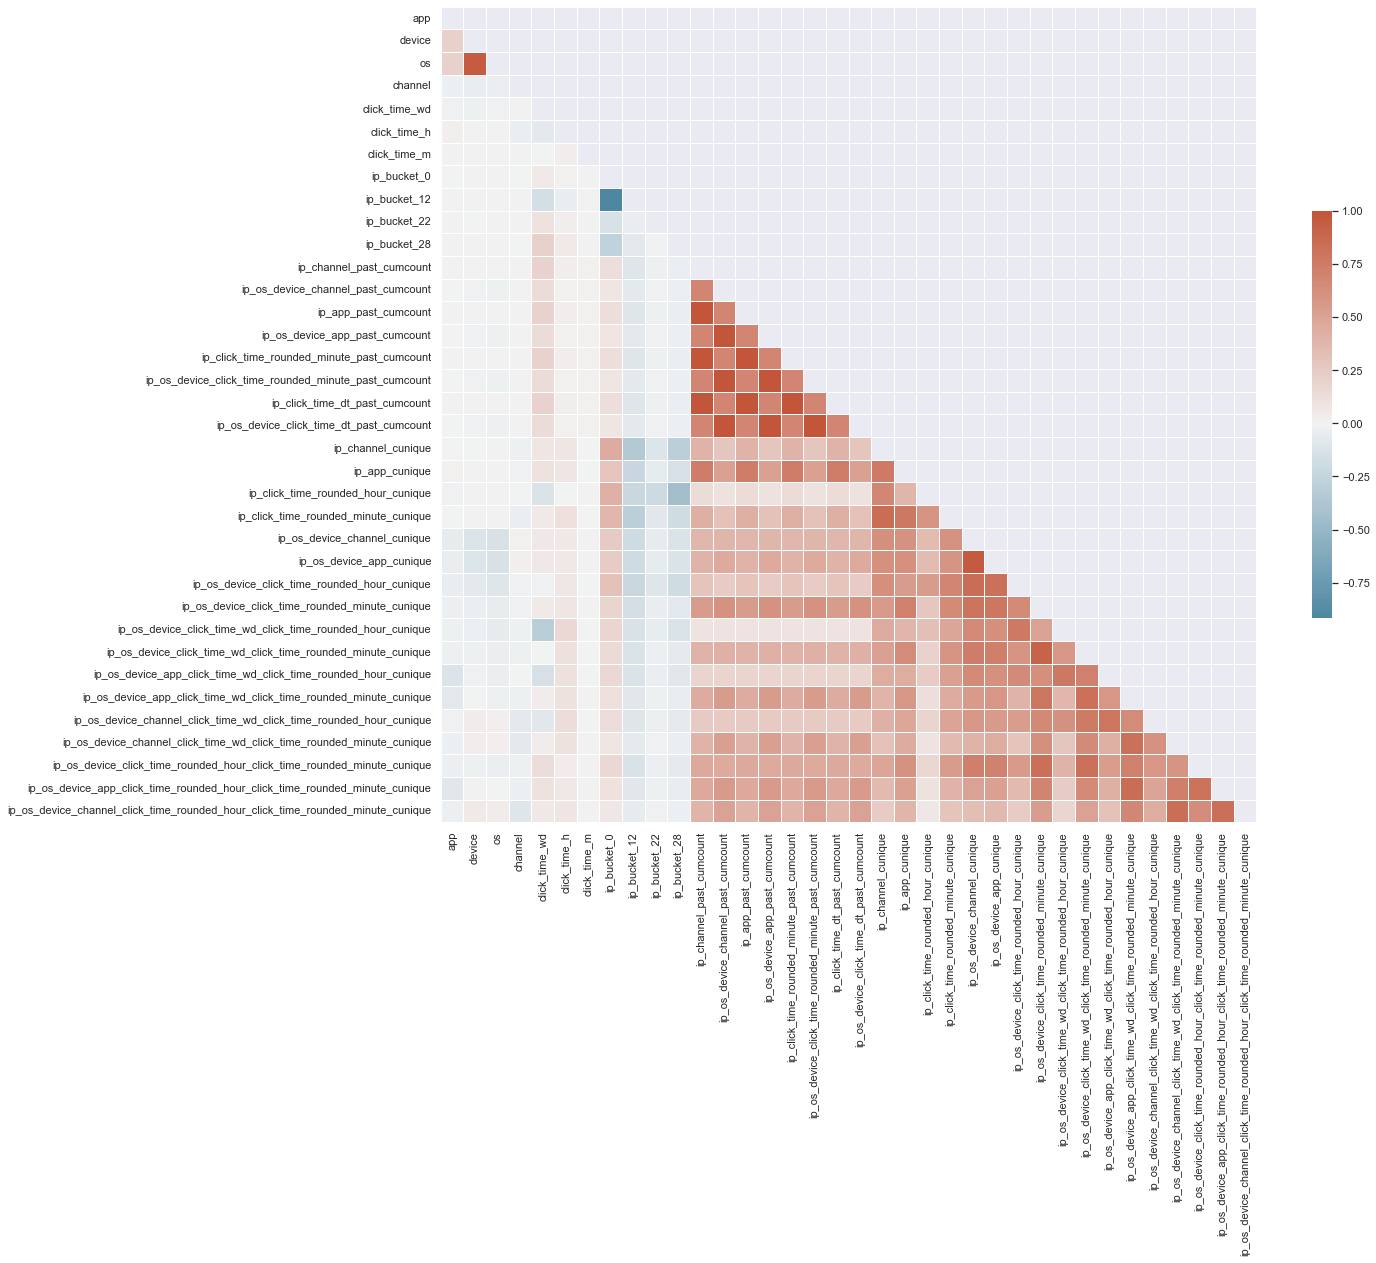

In [39]:
features_correlation = train_test_df[feature_set_v1].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(features_correlation, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(features_correlation, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

We can see that there are multiple correlated features, we will handle the feature selection part in the final model (next task).

In [16]:
from datetime import datetime

train_validation_df.to_pickle(f'./datasets/ds_train_val_{datetime.now().strftime("%Y%m%d_%H%M")}.pkl')
train_test_df[train_test_df.ds_type=='train'].to_pickle(f'./datasets/ds_full_train_{datetime.now().strftime("%Y%m%d_%H%M")}.pkl')
train_test_df[train_test_df.ds_type=='test'].to_pickle(f'./datasets/ds_full_test_{datetime.now().strftime("%Y%m%d_%H%M")}.pkl')

gc.collect()

54

# Base model

The plan here was to evaluate a couple of models initially with simple train / valdation split.

We evaluated:

- KNN (Had a problem dealing with nulls in distance metric + distance of categorical features)
- Logistic regression (had bad performance, this is expected since giving weight to categorical numeric features as if they were continuous variables is a problem)
- Random forest (Stopped the training after 11 hours~ - took too long to converge since we did not limit the depth here)
- Gradient boosting:
    - catboost: Had good results but training was taking more than 17 hours so we stopped here
    - lightgbm: Had great performance (even too good that we might want to suspect some leakage / etc.), tarining was fast though so we decided to keep working with it.
    - XGboost: Gave up on this option as we saw great results with catboost and lightGBM

In [7]:
train_val_df = pd.read_pickle('./datasets/ds_train_val_20220115_2241.pkl')
full_train_df = pd.read_pickle('./datasets/ds_full_train_20220115_2303.pkl')
full_test_df = pd.read_pickle('./datasets/ds_full_test_20220115_2305.pkl')

In [8]:
train_cols = train_val_df.columns.tolist()
print(train_cols)

['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time', 'is_attributed', 'click_id', 'ds_type', 'click_time_dt', 'click_time_wd', 'click_time_h', 'click_time_rounded_hour', 'click_time_m', 'click_time_rounded_minute', 'ip_prev_click_delta', 'ip_next_click_delta', 'ip_os_prev_click_delta', 'ip_os_next_click_delta', 'ip_channel_prev_click_delta', 'ip_channel_next_click_delta', 'ip_app_prev_click_delta', 'ip_app_next_click_delta', 'ip_bucket_0', 'ip_bucket_12', 'ip_bucket_22', 'ip_bucket_28', 'ip_channel_past_cumcount', 'ip_channel_future_cumcount', 'ip_os_device_channel_past_cumcount', 'ip_os_device_channel_future_cumcount', 'ip_app_past_cumcount', 'ip_app_future_cumcount', 'ip_os_device_app_past_cumcount', 'ip_os_device_app_future_cumcount', 'ip_click_time_rounded_minute_past_cumcount', 'ip_click_time_rounded_minute_future_cumcount', 'ip_os_device_click_time_rounded_minute_past_cumcount', 'ip_os_device_click_time_rounded_minute_future_cumcount', 'ip_click_time_dt_past_

In [9]:
test_cols = full_test_df.columns.tolist()
print(test_cols)

['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time', 'is_attributed', 'click_id', 'ds_type', 'click_time_dt', 'click_time_wd', 'click_time_h', 'click_time_rounded_hour', 'click_time_m', 'click_time_rounded_minute', 'ip_prev_click_delta', 'ip_next_click_delta', 'ip_os_prev_click_delta', 'ip_os_next_click_delta', 'ip_channel_prev_click_delta', 'ip_channel_next_click_delta', 'ip_app_prev_click_delta', 'ip_app_next_click_delta', 'ip_bucket_0', 'ip_bucket_12', 'ip_bucket_22', 'ip_bucket_28', 'ip_channel_past_cumcount', 'ip_channel_future_cumcount', 'ip_os_device_channel_past_cumcount', 'ip_os_device_channel_future_cumcount', 'ip_app_past_cumcount', 'ip_app_future_cumcount', 'ip_os_device_app_past_cumcount', 'ip_os_device_app_future_cumcount', 'ip_click_time_rounded_minute_past_cumcount', 'ip_click_time_rounded_minute_future_cumcount', 'ip_os_device_click_time_rounded_minute_past_cumcount', 'ip_os_device_click_time_rounded_minute_future_cumcount', 'ip_click_time_dt_past_

### Simple dataset split

In [10]:
# Splitting the train to train-validation with 90%/10% split (to mimic the ratio of the train vs. test size which is is about 89% vs. 11%)
train_size = train_val_df.shape[0]
train_end = round(train_size * 0.9)

# We leave a small gap between train and validation to avoid leakage of similar sessions
validation_start = round(train_size * 0.91)

# Partial train (as part of train-validation split)
train_x = train_val_df[:train_end][[i for i in train_val_df.columns.tolist() if i != 'is_attributed']]
train_y = train_val_df[:train_end].is_attributed

# Validation
validation_x = train_val_df[validation_start:][[i for i in train_val_df.columns.tolist() if i != 'is_attributed']]
validation_y = train_val_df[validation_start:].is_attributed

# Full train
full_train_x = train_val_df[[i for i in train_val_df.columns.tolist() if i != 'is_attributed']]
full_train_y = train_val_df.is_attributed

# Test
test_x = full_test_df[[i for i in full_test_df.columns.tolist() if i != 'is_attributed']]

### KNN vs. LR vs. RF

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

seed = 42

models = {
    "knn": KNeighborsClassifier(), # problem dealing with nulls in distance metric + distance of cat features
    "lr": LogisticRegression(random_state=seed), # Had bad performance (expected as weights per categorical feature might be bad)
    "rf": RandomForestClassifier(n_estimators=200, max_depth=50, random_state=seed) # Long training and boosting algorithms had better performance
}

**Below are attempts to use the more basic models (KNN / LR / RF) - They all had worse performance compared to boosting algorithms so we commented them out**

In [11]:
# from sklearn.metrics import roc_auc_score

# gc.collect()

# fitted_models = {}

# # For the sklearn classifiers we have to handle nulls - we will replace them with -1 (non-existing const) just for baseline model evaluation
# # Other models like gradient boosting models that we will try have their strategy for nulls built in.
# train_x_fillna = train_x.fillna(-1)
# val_x_fillna = validation_x.fillna(-1)
# gc.collect()

# for model in models.keys():    

#     LOGGER.info(f"Starting fitting for model '{model}'")
#     clf = models.get(model)
    
#     clf.fit(train_x_fillna[feature_set_v1], train_y)
    
#     LOGGER.info(f"Running predictions for model '{model}'")
#     train_preds = clf.predict_proba(train_x_fillna[feature_set_v1])[:, 1]
#     validation_preds = clf.predict_proba(val_x_fillna[feature_set_v1])[:, 1]

#     train_auc = roc_auc_score(y_true=train_y, y_score=train_preds)
#     val_auc = roc_auc_score(y_true=validation_y, y_score=validation_preds)
#     fitted_models[model] = clf
    
#     LOGGER.info(f"Model - '{model}' | Train AUC - {train_auc} | Validation AUC {val_auc}")
#     gc.collect()


### Gradient boosting models

##### LightGBM

In [12]:
import lightgbm as lgb


# Params set after playing with them a little bit
lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc', # This is the evaluation metric of our problem based on the kaggle evaluation
        'learning_rate': 0.03, 
        'num_leaves': 31, # Read the docs and some common practices to avoid overfitting, took this number for start
        'max_bin': 100,  # Max bins per feature,
        'scale_pos_weight': 200, # Trying to dealing with the imbalance problem
        'random_state': seed
    }

# Creating the datasets

LOGGER.info("Creating datasets for LightGBM training \n")

lgb_train = lgb.Dataset(train_x[feature_set_v1].values, label=train_y, feature_name=feature_set_v1, categorical_feature=cat_features_v1)
lgb_valid = lgb.Dataset(validation_x[feature_set_v1].values, label=validation_y, feature_name=feature_set_v1, categorical_feature=cat_features_v1)

gc.collect()

01/16/2022 12:45:10PM | INFO | BasicLogger | Creating datasets for LightGBM training 



4

In [13]:
from lightgbm import early_stopping, log_evaluation

LOGGER.info("Starting to train LGBM model")

results = {}

clf_lgb = lgb.train(lgb_params, 
                    lgb_train, 
                    valid_sets=[lgb_train, lgb_valid], 
                    valid_names=['train','validation'],
                    evals_result=results, 
                    callbacks=[early_stopping(50), log_evaluation(1)],
                    num_boost_round=1000)

LOGGER.info("Train ended")

train_auc = results['train']['auc'][clf_lgb.best_iteration-1]
valid_auc = results['validation']['auc'][clf_lgb.best_iteration-1]

LOGGER.info(f"Train AUC - [{train_auc}] | Validation AUC [{valid_auc}]")

01/16/2022 12:45:37PM | INFO | BasicLogger | Starting to train LGBM model
/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 56951, number of negative: 24132641
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.866132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 24189592, number of used features: 36


/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002354 -> initscore=-6.049129
[LightGBM] [Info] Start training from score -6.049129
[1]	train's auc: 0.965244	validation's auc: 0.960937
Training until validation scores don't improve for 50 rounds
[2]	train's auc: 0.970143	validation's auc: 0.966431
[3]	train's auc: 0.971332	validation's auc: 0.966814
[4]	train's auc: 0.972502	validation's auc: 0.967686
[5]	train's auc: 0.973231	validation's auc: 0.967959
[6]	train's auc: 0.973712	validation's auc: 0.968152
[7]	train's auc: 0.973953	validation's auc: 0.96813
[8]	train's auc: 0.974569	validation's auc: 0.968092
[9]	train's auc: 0.974757	validation's auc: 0.968138
[10]	train's auc: 0.974935	validation's auc: 0.968075
[11]	train's auc: 0.975163	validation's auc: 0.968133
[12]	train's auc: 0.975427	validation's auc: 0.968417
[13]	train's auc: 0.975562	validation's auc: 0.968474
[14]	train's auc: 0.975746	validation's auc: 0.968444
[15]	train's auc: 0.975863	validation's auc: 0.968544
[16]	

01/16/2022 12:54:37PM | INFO | BasicLogger | Train ended
01/16/2022 12:54:37PM | INFO | BasicLogger | Train AUC - [0.9805352033219399] | Validation AUC [0.9695793371447949]


[120]	train's auc: 0.983383	validation's auc: 0.969462
Early stopping, best iteration is:
[70]	train's auc: 0.980535	validation's auc: 0.969579


In [17]:
clf_lgb.save_model(f'./models/lgbm_train_val_{datetime.now().strftime("%Y%m%d_%H%M")}.lgbm')

We are getting too good results here (comapred to previous experiments we've performed on RF / LR / KNN).


Some comments on it:
1. We found as part of our brainstorm that we have a leakage in our features (count unique features count the appearances over all the data), we did not have time to handle this problem, we plan to fix this in the final model (next task)
2. We will optimize the model parameters later (in the final model task)
    - Trying to use grid search / opotuna 
    - Optimize sample weights as we discussed in our EDA (higher weights to the positive sample / to samples in hours similar to the test time or close to the test time)
3. We've used the test data in the feature calculation, we need to create 2 setups:
    - Use the train + validation for feature extraction, train and optimize param (this will be better evaluation of the performance in the test set - since we have features that look on the future behaviour and in the test set they might have null values)
    - Use the full train (train + validation) and predict on test (with the best params after the parameters tuning)

<Figure size 432x288 with 0 Axes>

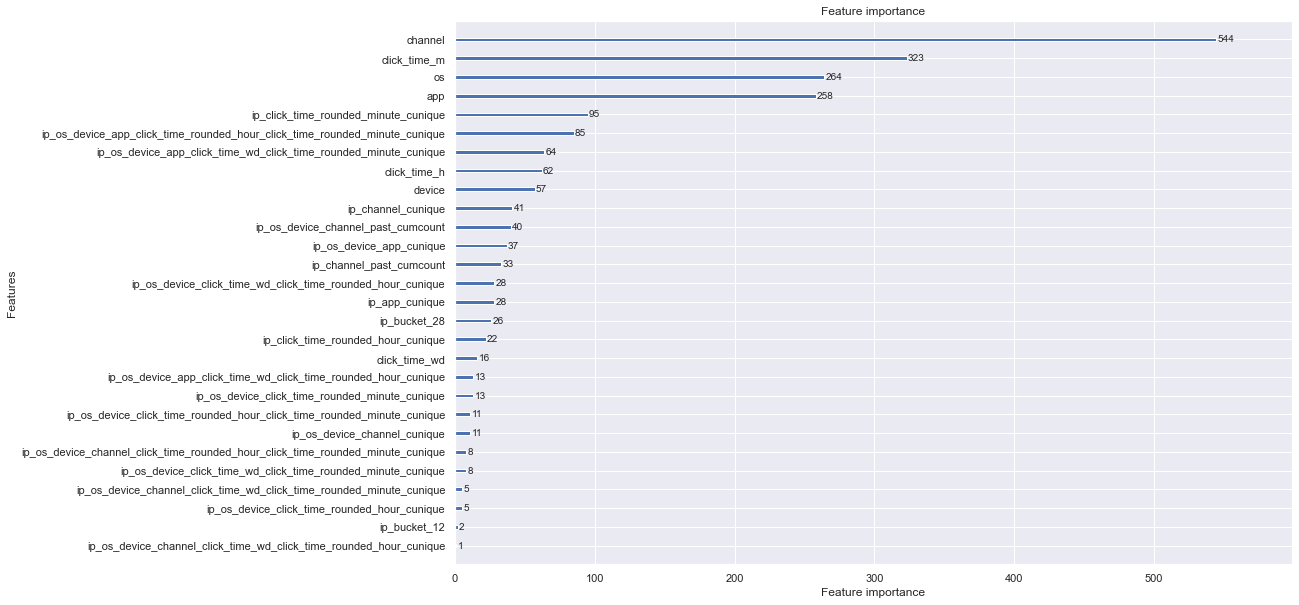

In [31]:
lgb.plot_importance(clf_lgb, max_num_features=100, figsize=(15, 10))
plt.show()

#### Catboost

We've stopped the catboost training after 11 hours~

Seems like lightGBM is much faster and yields almost the same results.

In [37]:
import catboost

LOGGER.info("Preparing catboost datasets")
train_x_cbt = train_x[feature_set_v1]
validation_x_cbt = validation_x[feature_set_v1]

# Categorical features must be integers
for feature in cat_features_v1:
    train_x_cbt[feature] = train_x_cbt[feature].astype(np.int32)
    validation_x_cbt[feature] = validation_x_cbt[feature].astype(np.int32)

clf_cat = catboost.CatBoostClassifier(iterations=200,
                                      loss_function='Logloss',
                                      eval_metric='AUC',
                                      custom_metric='AUC',
                                      learning_rate=0.05)

LOGGER.info("Starts catboost fitting")
clf_cat.fit(train_x_cbt[feature_set_v1], 
            train_y, 
            cat_features=cat_features_v1, 
            eval_set=(validation_x_cbt, validation_y), 
            early_stopping_rounds=20, 
            verbose=10,
            snapshot_file='./models/cbt_snap.snapshot',
            snapshot_interval=20)

01/15/2022 01:21:18AM | INFO | BasicLogger | Preparing catboost datasets
/var/folders/hp/1nwbq3_d6233ql5yg61wlxg02r6qjf/T/ipykernel_36120/3085808156.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x_cbt[feature] = train_x_cbt[feature].astype(np.int32)
/var/folders/hp/1nwbq3_d6233ql5yg61wlxg02r6qjf/T/ipykernel_36120/3085808156.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_x_cbt[feature] = validation_x_cbt[feature].astype(np.int32)
01/15/2022 01:21:40AM | INFO | BasicLogger | Star

0:	test: 0.7675777	best: 0.7675777 (0)	total: 36.4s	remaining: 10h 6m 18s
10:	test: 0.8250094	best: 0.8265871 (9)	total: 7m 26s	remaining: 11h 9m 5s
20:	test: 0.9107606	best: 0.9107606 (20)	total: 12m 1s	remaining: 9h 20m 19s
30:	test: 0.9203555	best: 0.9203555 (30)	total: 17m 28s	remaining: 9h 6m 1s
40:	test: 0.9230300	best: 0.9230300 (40)	total: 22m 46s	remaining: 8h 52m 45s
50:	test: 0.9271251	best: 0.9271251 (50)	total: 27m 51s	remaining: 8h 38m 25s
60:	test: 0.9319190	best: 0.9319190 (60)	total: 32m 41s	remaining: 8h 23m 9s
70:	test: 0.9389921	best: 0.9389921 (70)	total: 37m 23s	remaining: 8h 9m 16s
80:	test: 0.9433409	best: 0.9433409 (80)	total: 42m	remaining: 7h 56m 33s
90:	test: 0.9463391	best: 0.9463391 (90)	total: 47m 35s	remaining: 7h 55m 22s
100:	test: 0.9483456	best: 0.9483456 (100)	total: 53m 46s	remaining: 7h 58m 42s
110:	test: 0.9500673	best: 0.9500673 (110)	total: 1h 2m 4s	remaining: 8h 17m 11s
120:	test: 0.9520864	best: 0.9520864 (120)	total: 1h 9m 36s	remaining: 8h 2

KeyboardInterrupt: 

### Final baseline model to predict on test

We will use the lightGBM model with the same params we've found in the training on train+validation.

This time we will train on the entire train set and predict on the test set.

##### Fitting

In [19]:
# Creating the training dataset
LOGGER.info("Creating datasets for LightGBM training \n")
lgb_train_full = lgb.Dataset(full_train_x[feature_set_v1].values, label=full_train_y, feature_name=feature_set_v1, categorical_feature=cat_features_v1)
gc.collect()

01/16/2022 12:55:37PM | INFO | BasicLogger | Creating datasets for LightGBM training 



27

In [20]:
LOGGER.info("Starting to train LGBM model")

final_results = {}
clf_lgb_final = lgb.train(lgb_params, 
                    lgb_train_full, 
                    valid_sets=[lgb_train_full], 
                    valid_names=['train'],
                    evals_result=final_results, 
                    callbacks=[log_evaluation(1)],
                    num_boost_round=clf_lgb.best_iteration)

LOGGER.info("Train ended")

train_auc = final_results['train']['auc'][clf_lgb.best_iteration-1]

LOGGER.info(f"Train AUC - [{train_auc}] | Validation AUC [{valid_auc}]")

01/16/2022 12:55:58PM | INFO | BasicLogger | Starting to train LGBM model
/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 64876, number of negative: 26812448
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.160046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2319
[LightGBM] [Info] Number of data points in the train set: 26877324, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002414 -> initscore=-6.024144
[LightGBM] [Info] Start training from score -6.024144
[1]	train's auc: 0.964787
[2]	train's auc: 0.970873
[3]	train's auc: 0.972372
[4]	train's auc: 0.973548
[5]	train's auc: 0.974046
[6]	train's auc: 0.974497
[7]	train's auc: 0.974704
[8]	train's auc: 0.974856
[9]	train's auc: 0.974947
[10]	train's auc: 0.975209
[11]	train's auc: 0.975476
[12]	train's auc: 0.975778
[13]	train's auc: 0.976002
[14]	train's auc: 0.976101
[15]	train's auc: 0.976203
[16]	train's auc: 0.97632
[17]	train'

01/16/2022 01:01:57PM | INFO | BasicLogger | Train ended
01/16/2022 01:01:57PM | INFO | BasicLogger | Train AUC - [0.9802926770908973] | Validation AUC [0.9695793371447949]


In [22]:
clf_lgb_final.save_model(f'./models/lgbm_baseline_final_{datetime.now().strftime("%Y%m%d_%H%M")}.lgbm')

##### Generating the final test predictions

In [24]:
from datetime import datetime

best_model = clf_lgb_final
selected_features = feature_set_v1

full_test_df['is_attributed'] = best_model.predict(full_test_df[selected_features])

res = full_test_df[['click_id', 'is_attributed']].rename({'click_id': 'Id', 'is_attributed': 'Expected'}, axis=1)
res.Id = res.Id.astype(np.int64)

save_path = f'./predictions/test_preds_{datetime.now().strftime("%Y%m%d_%H%M")}.csv'

res.to_csv(save_path, index=False)

LOGGER.info(f'Saved latest test results to: {save_path}')

01/16/2022 01:06:52PM | INFO | BasicLogger | Saved latest test results to: ./predictions/test_preds_20220116_1306.csv


### Sumamry & next steps

This was just a "bruteforce" model to test all the "simple" features and ideas we had for splitting the data and creating an initial baseline model that we should analyze furtherly and improve.

We did not tackle multiple gaps that we plan to tackle in the final model:

1. Leakage - After a brainstorm on the "too good" performance we got, we found that we have a leakage in the count unique features (which also count validation / test appearances and not just on the history - we can only count train appearances to evaluate such features), we will fix their calculation to use only "history" per click and it's entities - will be fixed in our final model (next task)!
2. Time based cross validation and parameters tuning - We need to think on the CV folds strategy, how we handle the time gap in the data (see bullet #2 here), using optimization frameworks like optuna, thinking on "how long" do we want to look back in the history we have when we calculate our features.
3. Sample weights - As we mentioned in our EDA, we would like to give different weight to different samples (here we only increased the positive sample weights), we need to think on the strategy here, some ideas we had:
    - Giving bigger sample weight to samples near the train end (as they are the closest to the test set).
    - Evaluating different weights over time (older samples - lower weight, newest - bigger weights). 
4. Feature selection - 
    - We did not use any feature selection here - We implemented multiple features as as we saw in the correlation matrix, there is a very high correlation in multiple features. In addition, we did not perform feature analysis to the features we created (correlation with the label for example, binning evaluation, etc.). 
    - We can already see from feature importance chart that there is very strong affect for time based features and combinations/aggregative features. We could continue analyzing it before choosing the final model.
5. Error analysis - We did not perform any error analysis here and another iteration of the model - We plan to analyze the samples where we had mistakes, maybe adding additional features for them (we can use SHAP in our case).
6. Stacking - Based on the error analysis, we might want to consider stacking different models / creating sub-models for specific phenomenas and combining the results of multiple models.
